In [1]:
from eda_fn import*
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recordlinkage as rl 
from recordlinkage.index import Block
import re

In [4]:
df_frame = pd.read_csv(r"C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\tbl_listing_info_amsterdam_20200104.csv") # Main data frame
df_new = pd.read_csv(r"C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\tbl_listings_research_18_02_2022.csv") # Extra columns including more pictures 
df_extra = pd.read_csv(r"C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\tbl_listing_description_07_03_2022.csv") # description of listing dutch/english

#Baseline data sets
df_phones_cat = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\phones_catalog.csv', sep='\|\|', engine='python')
df_phones_notcat = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\phones.csv', sep='\|\|', engine='python')
df_pairs_baseline = pd.read_csv(r"C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\phones_phones_catalog_gold_standard_train.csv",sep=';')
df_phones_json_baseline_1 = pd.read_json(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\PhoneCatalog.json')
df_phones_json_baseline_2 = pd.read_json(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\phones.json')

In [5]:
print('Main dataf has:',len(df_frame.columns))
print('New data has', len(df_new.columns))

Main dataf has: 64
New data has 47


In [6]:
df_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23173 entries, 0 to 23172
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   wsa_listing_id                    23173 non-null  int64  
 1   customer_name                     23173 non-null  object 
 2   site                              23173 non-null  object 
 3   listing_id                        23173 non-null  object 
 4   registration_number               4600 non-null   object 
 5   house_name                        21888 non-null  object 
 6   city                              23173 non-null  object 
 7   postalcode                        23168 non-null  object 
 8   bedrooms                          21294 non-null  object 
 9   bathrooms                         9259 non-null   object 
 10  beds                              21751 non-null  object 
 11  person_capacity                   21135 non-null  float64
 12  host

In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5457 entries, 0 to 5456
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      5457 non-null   object 
 1   ListingId                 5457 non-null   int64  
 2   registration_number       4209 non-null   object 
 3   Bathrooms                 5447 non-null   float64
 4   Bedrooms                  5441 non-null   float64
 5   Beds                      5414 non-null   float64
 6   City                      5452 non-null   object 
 7   Listing_id_str            5457 non-null   int64  
 8   Instant_bookable          5457 non-null   object 
 9   Is_business_travel_ready  5457 non-null   object 
 10  Is_family_preferred       5457 non-null   object 
 11  Is_new_listing            5457 non-null   object 
 12  Lat                       5457 non-null   float64
 13  Lng                       5457 non-null   float64
 14  Localize

In [8]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50619 entries, 0 to 50618
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50619 non-null  int64 
 1   listingid    50619 non-null  int64 
 2   Description  50619 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [9]:
print('total listings descriptions',len(set(list(df_extra['listingid']))))

total listings descriptions 4672


In [10]:
# From the frames this columns seem to contain the same entries Host_first_name== User_first_name == User_Smart_name == HOst_Smart_name 
# from df_frame custumer name == city == City in df_new
# Some of the columns of df_new refer to the same column in df_frame but with different name
df_frame.rename(columns={'customer_name':'City','house_name':'Name','bathrooms':'Bathrooms','bedrooms':'Bedrooms',
                        'beds':'Beds','listing_id':'ListingId','instant_bookable':'Instant_bookable','is_new_listing':'Is_new_listing',
                        'lat':'Lat','lng':'Lng','region':'Neighborhood','person_capacity':'Person_capacity','picture_url':'Picture_url',
                        'host_name':'Host_first_name','host_id':'Host_id','property_type':'Property_type','room_type_category':'Room_type_category',
                        'room_type':'Room_type','space_type':'Space_type','host_picture':'Host_picture_url'},inplace= True)

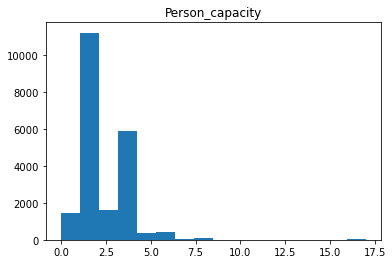

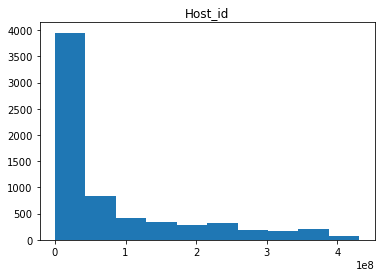

In [11]:
histogram(df_frame,'Person_capacity')
histogram(df_frame,'Host_id')

In [12]:
df_frame['ListingId'] = df_frame['ListingId'].str.replace('[A-Za-z]', '').astype('int64') # remove letters-ListingId has entries which start with a letter h123133... only in some sites
df_frame['Person_capacity'].fillna(0,inplace=True)   # There are Nan values which creates a conflict while converting all columns into the same dtype , turn them to 0 temporarily
df_frame['Host_id'].fillna(0,inplace=True) 
df_frame['Instant_bookable']= df_frame['Instant_bookable'].astype('int64') 
similar_columns = []
# Make every similar column match the dtype so it can be joined
for column in df_new.columns:
    if column in df_frame.columns: #Only use columns which are similar in both df
        dtype = df_new[column].dtypes
        dtype_2 = df_frame[column].dtypes
        similar_columns.append(column) # Save the similar keys in both dfs for joining
        if dtype == 'float64' and dtype!= dtype_2: # If the dtype needs to be float and they have different dtypes remove commas, numbers are 1,20 instead of 1.20 which is needed for conversion
            df_frame[column]= df_frame[column].str.replace(',', '.').astype(dtype)
        elif dtype!= dtype_2: # If they are not the same just change the dtype
            df_frame[column]= df_frame[column].astype(dtype) 




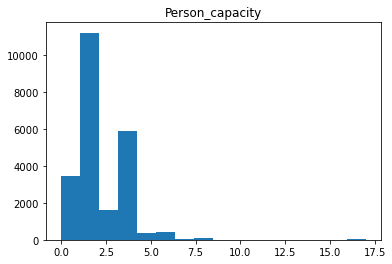

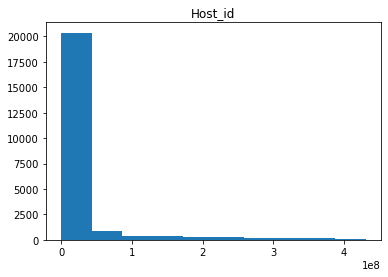

In [13]:
histogram(df_frame,'Person_capacity')
histogram(df_frame,'Host_id')


In [14]:
#Mergeing data 
df_merged = pd.merge(df_frame,df_new, on="ListingId",how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

#Dataframes per site
df_bnb = df_merged[df_merged['site'] == 'AIRBNB']
df_book = df_merged[df_merged['site'] == 'Booking']
df_exp = df_merged[df_merged['site'] == 'Expedia']
df_trip = df_merged[df_merged['site'] == 'Tripadvisor']
df_verb = df_merged[df_merged['site'] == 'VRBO']

In [15]:
print('AIRBNB total lisitngs : ',len(df_bnb))
print('Booking total lisitngs : ',len(df_book))
print('Expedia total lisitngs : ',len(df_exp))
print('Tripadvisor total lisitngs : ',len(df_trip))
print('VRBO total lisitngs : ',len(df_verb))

AIRBNB total lisitngs :  21173
Booking total lisitngs :  621
Expedia total lisitngs :  168
Tripadvisor total lisitngs :  523
VRBO total lisitngs :  688


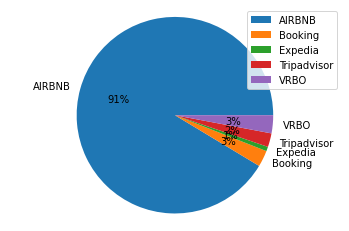

In [16]:
labels = 'AIRBNB', 'Booking', 'Expedia', 'Tripadvisor','VRBO'
sizes = [21173, 621, 168, 523,688]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%.0f%%',startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend()
plt.show()

In [17]:
"""histogram(df_merged,'Bedrooms')
histogram(df_merged,'Bathrooms')
histogram(df_merged,'Beds')
histogram(df_merged,'bad_ratings_count')
histogram(df_merged,'Is_new_listing')
histogram(df_merged,'host_listings_count_hist')
histogram(df_merged,'kpi_capacity_more_than_4')
histogram(df_merged,'kpi_capacity_more_than_6')
histogram(df_merged,'2021-08_available_days')
histogram(df_merged,'host_reviews_per_listing')
histogram(df_merged,'host_popularity_score_percentage')
histogram(df_merged,'host_reviews_per_listing')
histogram(df_merged,'host_reviews_per_year')
histogram(df_merged,'Reviews_count')
histogram(df_merged,'Picture_count')"""

"histogram(df_merged,'Bedrooms')\nhistogram(df_merged,'Bathrooms')\nhistogram(df_merged,'Beds')\nhistogram(df_merged,'bad_ratings_count')\nhistogram(df_merged,'Is_new_listing')\nhistogram(df_merged,'host_listings_count_hist')\nhistogram(df_merged,'kpi_capacity_more_than_4')\nhistogram(df_merged,'kpi_capacity_more_than_6')\nhistogram(df_merged,'2021-08_available_days')\nhistogram(df_merged,'host_reviews_per_listing')\nhistogram(df_merged,'host_popularity_score_percentage')\nhistogram(df_merged,'host_reviews_per_listing')\nhistogram(df_merged,'host_reviews_per_year')\nhistogram(df_merged,'Reviews_count')\nhistogram(df_merged,'Picture_count')"

In [18]:
#Checking complete postal code
complete_postalcode = 0
for x in df_merged['postalcode'].dropna():
    if re.search('[A-Za-z]', x):
        complete_postalcode+=1
print('Complete postal code format 1101MX :',complete_postalcode)
print('Total postalcode:',len(df_merged['postalcode'].dropna()))

Complete postal code format 1101MX : 23050
Total postalcode: 23168


In [19]:
""" DROP:
    drop_list = ['Host_id','first_found_date','listing_published','listing_can_book','Listing_id_str',
                'Public_address','Localized_city',
                'User_Id','User_First_name','User_Smart_name','Host_smart_name','User_Thumbnail_url']
    
    Host_id : specific for each log in Airbnb only , for the rest 0 are Nan values therefore graph looks like it 
    first_found_date : complete only for bnb for the rest only 2 or 4 values are the same in all entries, why will this help the model
    listing_published: bnb an booking {-1,0} for the rest all {-1}
    listing_can_book: bnb{0,1} , for the rest 0 , what 
    Listing_id_str: another identifier only for bnb not extra info
    
    Host_thumbnail_url : same as Host profile pic but incomplete
    
    Public_address: bnb only seems similar to neighbourhood
    Localized_city: bnb only , same as neighbourhood just use neighbourhood as is more complete
    User_Id: bnb another identifier
    User_First_name: same as user smart name
    User_Smart_name: same as user smart name
    Host_smart_name: less entries than Host_first_name
    User_Thumbnail_url : same as host_Thumbnail_url
    **Xl_picture_url : seems to be same as picture url but only bnb double check if there are broken links 
    
    MAYBE DROP:
    
    Instant_bookable: Bookingtrip,exp,verb all 0s
    Is_new_listing: Bookingtrip,exp,verb all 0s
    
    Property_type_id: seems like categories, will it be useful ?
    Picture_count: How picture count will help ?
    *Is_business_travel_ready: bnb only {0,'False'} 
    *Is_family_preferred : bnb only {0,'False'}
    Host_has_profile_pic: only bnb -1,0,false,true will it be helpful?
    Host_is_superhost: only bnb -1,0,false,true will it be helpful?
    
    
    
    TO BE CLEANED:
    :) Name : Get rid of 'Aparthotel\r\nAmsterdam' that appears in Booking entries
           In Trip Advisor '\x91' \x92 appears quite often  
           Vrb \x96  w/
           Airbnb , expedia looks good
    :) Bedrooms: Clean for 0s many 0s means Nan?  Airbnb has 10,12,15,50
              exp seems good  
              Trip advisor only 0s
              Booking only 1
              vrbo seems complete
    :) Bathrooms: many 0s, in Booking, trip advisor, exp, vrbo all 0s actually
    
    :) Beds: trip, book, exp,verbo all 0s **ask if 0s are wrong for bnb checked multiple and actually wrong
    
    **Person_capacity: booking values seem weird {0, 5, 6, 7, 8, 12, 17} **checked and actually most 0 are wrong
                     trip advisor all 0s  
                     expedia, bnb, vrbo seems good  **cant access the websites for the rest the info seem to be wrong??
                     
    ?(maybe do not use) Property_type : bnb, verb okay , 
                    booking has but different categories , so how to combine?
                    trip,exp nan
                    
    :) Host_first_name : Only in Airbn and Vrbo complete for the rest are Nan values, 
                      book : 'unknown' , trip,exp: 'nan',
    
    
    
    
    kpi_capacity_more_than_6\4 : only bnb{-1,0}, rest nan                  
    :) kpi_instant_bookable: bnb complete, the rest have 0 values
    kpi_host_lists_10_or_more:  bnb complete, the rest nan
    2021-10_available_days: only bnb need to be converted to float {3,14}
    :)reviews_count : bnb,verb complete, book,exp empty, trip all 0.0
    
    ALMOST REDY TO USE:
    postalcode: complete for all however for bnb almost half of the entries after correcting for oukbend as nan
    Neighborhood: complete (maybe use for blooking)
    
    Lat,Lng : some nan but ready to use
    Picture_url: trip advisor, expedia empty the rest looks good (is link not pic already)
    listing_url : compelete 
    Host_picture_url:  bnb and vrbp only  ; Trip advisor, booking, expedia empty 
    
    kpi_host_lists_multiple: bnb only {-1,0}
    
    Host_thumbnail_url = only bnb picture of host small!
    
    Room_type_category: bnb only, the rest are nan
    Room_type: bnb only in ducth, the rest are nan
    Space_type: bnb only in ducth, the rest are nan
    booking_count: bnb complete rest nan
     
    host_listings_count_hist: bnb complete rest nan
    days_active: bnb complete rest nan
    host_start_month:  bnb complete rest nan
    host_start_year: bnb complete rest nan
    reviews_year,reviews_6\4\1_months,rating_avg,bad_ratings_count: bnb complete rest nan
"""

set(list(df_merged['site']))


{'AIRBNB', 'Booking', 'Expedia', 'Tripadvisor', 'VRBO'}

In [20]:
#drop Nan names? mostly incomplete check again after deciding which feautures to take 1285 Nan
# Columns which are mainly empty or have similar information that other columns 
drop = ['wsa_listing_id','city','City','2021-06_available_days','registration_number',
        '2021-07_available_days', '2022-01_available_days','Host_id','first_found_date','listing_published',
        'listing_can_book','Listing_id_str', 'Public_address','Localized_city',
        'User_Id','User_First_name','User_Smart_name','Host_smart_name','User_Thumbnail_url','Is_business_travel_ready','Is_family_preferred','User_Is_superhost','User_Has_profile_pic',
        'Property_type']
df_merged.drop(columns = drop ,inplace=True)

# Cleaning Postalcode
df_merged['postalcode'] = df_merged['postalcode'].map(lambda x: float("NaN") if x =='Onbekend' else x)

#Cleaning negatives ones , false and true entries
for column in df_merged.columns:
    try:
        df_merged[column] = df_merged[column].astype('int64')
    except ValueError:
        if column in  ['Host_is_superhost','Host_has_profile_pic']:
            df_merged[column] = df_merged[column].map(helper_negative_ones)
              
#Replace int by floats 198,00
week_days = ['2021-08_available_days',
       '2021-09_available_days', '2021-10_available_days',
       '2021-11_available_days', '2021-12_available_days',
       '2022-02_available_days', '2022-03_available_days',
       '2022-04_available_days']

for column in week_days:
       df_merged[column] = df_merged[column].str.replace(',', '.').astype('float64')


#Cleaning of data
df_merged['Name'] = df_merged['Name'].str.replace('Apartments\r\n', '').str.replace('Apartment\r\n', '').str.replace('Aparthotel\r\n', '')
df_merged['Name'] = df_merged['Name'].str.replace('\x92', '').str.replace('\x91', '').str.replace('\x96', '').str.replace('w/', '')
df_merged['Bedrooms'][df_merged['site']=='Booking'] = df_merged['Bedrooms'][df_merged['site']=='Booking'].replace(1.0,float("nan")) 
df_merged['Bedrooms'][df_merged['site']=='Tripadvisor'] = df_merged['Bedrooms'][df_merged['site']=='Tripadvisor'].replace(0,float("nan")) 
df_merged['Bathrooms'][df_merged['site']!='AIRBNB']= df_merged['Bathrooms'][df_merged['site']!='AIRBNB'].replace(0,float("nan"))
df_merged['Beds']= df_merged['Beds'].replace(0,float("nan"))
df_merged['Host_first_name'] = df_merged['Host_first_name'].replace('unknown', float("nan"))
df_merged['kpi_instant_bookable'][df_merged['site']!='AIRBNB'] =df_merged['kpi_instant_bookable'][df_merged['site']!='AIRBNB'].replace(0,float("nan"))
df_merged['reviews_count'][df_merged['site']=='Tripadvisor']= df_merged['reviews_count'][df_merged['site']=='Tripadvisor'].replace(0,float("nan"))
df_merged['days_active'] = df_merged['days_active'].str.replace(',', '.').astype('float64')
df_merged['reviews_year'] = df_merged['reviews_year'].str.replace(',', '.').astype('float64')
df_merged['reviews_6_months'] = df_merged['reviews_6_months'].str.replace(',', '.').astype('float64')
df_merged['reviews_3_months'] = df_merged['reviews_3_months'].str.replace(',', '.').astype('float64')
df_merged['reviews_1_month'] = df_merged['reviews_1_month'].str.replace(',', '.').astype('float64')
df_merged['bad_ratings_count'] = df_merged['bad_ratings_count'].str.replace(',', '.').astype('float64')
df_merged['year_total_available'] = df_merged['year_total_available'].str.replace(',', '.').astype('float64')

#df_merged['Property_type'] = df_merged['Property_type'].str.replace('\r\n1', '').str.replace('\r\n2', '').str.replace('\r\n4', '')

#Clean remove punctuation lowercase Neighborhood, string like values
df_merged['Neighborhood'] = df_merged['Neighborhood'].map(clean_string) 
df_merged['Name']= df_merged['Name'].map(clean_string)
df_merged['Room_type_category']= df_merged['Room_type_category'].map(clean_string)
df_merged['Room_type']= df_merged['Room_type'].map(clean_string)
df_merged['Space_type']= df_merged['Space_type'].map(clean_string) 
df_merged['Host_first_name']= df_merged['Host_first_name'].map(clean_string)

<ipython-input-20-9fcaa4091c06>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Bedrooms'][df_merged['site']=='Booking'] = df_merged['Bedrooms'][df_merged['site']=='Booking'].replace(1.0,float("nan"))
<ipython-input-20-9fcaa4091c06>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Bedrooms'][df_merged['site']=='Tripadvisor'] = df_merged['Bedrooms'][df_merged['site']=='Tripadvisor'].replace(0,float("nan"))
<ipython-input-20-9fcaa4091c06>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [196]:
#df_merged[df_merged['last_found_date'].isna()]

In [195]:
clean_descrp(df_extra['Description'][df_extra['listingid'] == 10008030][0])

def join(strings):
    final_string = ''
    for x in strings:
        x = clean_descrp(x)
        if not re.match(x,final_string):
            final_string += x
            final_string += ' '
    return final_string
check = [x for x in df_extra['Description'][df_extra['listingid'] == 10008030]]
join(check)

'authentic ground floor house in the lively neighbourhood  de pijp  de ruimtethe dining room has a huge window makes you feel like sitting on the sidewalk  and the same is at the  orangery  at the back where you have a good connection with the garden  south  and a lot of light  a lot of the original  details are still there  supplementary to the modern warm design of the interior and furniture  most of the furniture is hand made the house is perfect for a couple with two kids   there are two children bedrooms with high sleepers for children age  onwards and a lot of toys and a pleasant playing field at the orangery there is one double sofabed   m wide  in the living room  i can also put a queensize bed in the orangery  the dining room has a huge window makes you feel like sitting on the sidewalk  and the same is at the  orangery  at the back where you have a good connection with the garden  south  and a lot of light  a lot of the original  details are still there  supplementary to the 

In [193]:
def clean_string(string):
    if type(string) == str:
        res = re.sub(r'[^\w\s]', ' ', string)
        res = res.lower()
        return res
    else:
        return np.nan
        
df_extra['Description'][df_extra['listingid'] == 10008030]

0    Authentic ground floor house in the lively nei...
1    Authentic ground floor house in the lively nei...
2    Authentic ground floor house in the lively nei...
3    The dining room has a huge window makes you fe...
4    Hulpdieren mogen mee en hoeven niet als huisdi...
5    Authentic ground floor house in the lively nei...
Name: Description, dtype: object

In [194]:
def clean_descrp(string):
    string = string.replace('<br />', '').replace('<b>', '').replace('</b>', '').replace('Registratienummer', '')
    string = string.replace('\x80', '').replace('\x92', '').replace('\x94', '').replace('\x91', '')
    string = re.sub('[0-9][0-9][0-9][0-9] [0-9][0-9][0-9][A-Z] [0-9][A-Z][0-9][0-9] [0-9][0-9][A-Z][0-9] [A-Z][0-9][A-Z][A-Z]','',string)
    string = re.sub('[0-9]','',string)
    
    string= clean_string(string)
    string =string.replace('br', '')
    return(string)

In [174]:
x = df_extra['Description'][df_extra['listingid'] == 10025641].iloc[7]
clean_descrp(x)

'hotel jansen is gelegen in amsterdam zuid dicht bij zuid wtc stationhet dichtstbijzijnde station  vannaar amsterdam zuid station naar hotel jansensnelste route  minuten   loop naar het metrostation zuid ongeveer  minuut van de treinen neem metro  naar isolatorweg uw halte na   minuten is henk sneevlietwegvanaf de henk sneevlietweg is het  minuten lopen naar het hotelkortste wandelroute  minuten  loop naar bustramstation zuid ongeveer  minuten van de treinen neem bus  naar station lelylaan na   minuten stop je op het aalsmeerpleinvanaf het aalsmeerplein is het  minuten lopen naar het hotel loop naar het tbwagebouw'

In [21]:
print('Total longitude',tot_nan_column(df_frame,'Lng'))
print('Total latitude',tot_nan_column(df_frame,'Lat'))
print('Total AirBnB longitude',tot_nan_column(df_bnb,'Lng'))
print('Total AirBnB latitude',tot_nan_column(df_bnb,'Lat'))
print('Total Booking longitude',tot_nan_column(df_book,'Lng'))
print('Total Booking latitude',tot_nan_column(df_book,'Lat'))
print('Total Expedia longitude',tot_nan_column(df_exp,'Lng'))
print('Total Expedia latitude',tot_nan_column(df_exp,'Lat'))
print('Total TripAD longitude',tot_nan_column(df_trip,'Lng'))
print('Total TripAD latitude',tot_nan_column(df_trip,'Lat'))
print('Total VRBO longitude',tot_nan_column(df_verb,'Lng'))
print('Total VRBO latitude',tot_nan_column(df_verb,'Lat'))

Total longitude 21921
Total latitude 21921
Total AirBnB longitude 19921
Total AirBnB latitude 19921
Total Booking longitude 621
Total Booking latitude 621
Total Expedia longitude 168
Total Expedia latitude 168
Total TripAD longitude 523
Total TripAD latitude 523
Total VRBO longitude 688
Total VRBO latitude 688


In [22]:
print('Total non nan Lat',len(df_merged['Lat']))
print('Total non nan Lon',len(df_merged['Lng']))
print('Total non nan Lat non null',len(df_merged['Lat'].dropna()))
print('Total non nan Lon non null',len(df_merged['Lng'].dropna()))

Total non nan Lat 23173
Total non nan Lon 23173
Total non nan Lat non null 21921
Total non nan Lon non null 21921


In [23]:
print('Total Postal codes',tot_nan_column(df_merged,'postalcode'),'out of', len(df_merged))
print('Total AirBnB Postal codes',tot_nan_column(df_bnb,'postalcode'),len(df_bnb))
print('Total Booking Postal codes',tot_nan_column(df_book,'postalcode'),len(df_book))
print('Total Expedia Postal codes',tot_nan_column(df_exp,'postalcode'),len(df_exp))
print('Total TripAD Postal codes',tot_nan_column(df_trip,'postalcode'),len(df_trip))
print('Total VRBO Postal codes',tot_nan_column(df_verb,'postalcode'),len(df_verb))

Total Postal codes 8789 out of 23173
Total AirBnB Postal codes 21171 21173
Total Booking Postal codes 619 621
Total Expedia Postal codes 168 168
Total TripAD Postal codes 523 523
Total VRBO Postal codes 687 688


In [27]:
#indexer = recordlinkage.Index()
indexer = rl.BlockIndex(on='Neighborhood')
candidate_links = indexer.index(df_merged)

print (len(candidate_links))

16613041


In [28]:
print(candidate_links[0:3])
print(df_merged['Neighborhood'].loc[2])
print(df_merged['Neighborhood'].loc[0])

MultiIndex([( 2, 0),
            (31, 0),
            (31, 2)],
           )
zuid
zuid


In [29]:
compare_cl = rl.Compare()

compare_cl.exact('Neighborhood','Neighborhood', label='Neighborhood')
compare_cl.geo('Lat','Lng','Lat','Lng',method='linear',label='Distance')

features = compare_cl.compute(candidate_links, df_merged)

In [30]:
features

Neighborhood  Distance
2     0                 1  0.032854
31    0                 1  0.000000
      2                 1  0.703605
49    0                 1  0.108769
      2                 1  0.604510
...                   ...       ...
16614 5302              1  0.937829
      10587             1  0.986317
      10961             1  0.971189
      12671             1  0.957603
      16097             1  0.915112

[16613041 rows x 2 columns]

In [32]:
matches_blocking = features[features['Distance'] > 0.95] # which threshold to use? 

pairs_tuples =list(matches_blocking.index) #list with all the possible matching pairs 150k

In [109]:

df_merged.to_csv('merged_clean_df.csv')

In [61]:
check = []
for x,y in matches_blocking.index:
    check.append(x) 
    check.append(y)
check = set(check)

In [31]:

rl.write_annotation_file(
    "annotation_bnb_vrb.json",
    features[features.sum(axis=1) > 2.999982  ].index,
    df_bnb[['wsa_listing_id', 'customer_name', 'site', 'listing_id', 'house_name', 'city', 'postalcode', 'bedrooms', 'bathrooms', 'beds', 'person_capacity', 'host_name', 'host_picture', 'instant_bookable', 'is_new_listing', 'region', 'lat', 'lng', 'picture_url', 'reviews_count', 'property_type', 'kpi_instant_bookable', 'listing_url', 'first_found_date', 'listing_published', 'listing_can_book']],
    df_verb[['wsa_listing_id', 'customer_name', 'site', 'listing_id', 'house_name', 'city', 'postalcode', 'bedrooms', 'bathrooms', 'beds', 'person_capacity', 'host_name', 'host_picture', 'instant_bookable', 'is_new_listing', 'region', 'lat', 'lng', 'picture_url', 'reviews_count', 'property_type', 'kpi_instant_bookable', 'listing_url', 'first_found_date', 'listing_published', 'listing_can_book']],
    dataset_a_name="AirBnb",
    dataset_b_name="VRBO"
)

In [23]:
result = rl.read_annotation_file('result_bnb_vrb.json')
print('Matches in AirBnB and VRBO with Postal code Lat, Ln:',len(result.links))
print('Non-matches in AirBnB and VRBO with Postal code Lat, Ln:',len(result.distinct))

Matches in AirBnB and VRBO with Postal code Lat, Ln: 19
Non-matches in AirBnB and VRBO with Postal code Lat, Ln: 87


In [26]:
result.links

MultiIndex([(12125, 22515),
            (12125, 22517),
            ( 8290, 22920),
            ( 4475, 23032),
            ( 4561, 23078),
            ( 8704, 23077),
            ( 9012, 23079),
            ( 9013, 22558),
            ( 9016, 22559),
            ( 9017, 22560),
            ( 9019, 23080),
            ( 9023, 22561),
            ( 9077, 23076),
            ( 7959, 22677),
            ( 7948, 22764),
            (14879, 22633),
            (10766, 22780),
            (10797, 23085),
            (20196, 22985)],
           )

In [24]:
#indexer = recordlinkage.Index()
indexer = rl.BlockIndex(on='postalcode')
candidate_links = indexer.index(df_bnb, df_trip)

print (len(candidate_links))

783


In [81]:
compare_cl = rl.Compare()

compare_cl.exact('postalcode', 'postalcode', label='postalcode')
compare_cl.numeric('lat', 'lat', label='lat')
compare_cl.numeric('lng', 'lng', label='lng')


features = compare_cl.compute(candidate_links, df_bnb, df_trip)

In [82]:
features.sum(axis=1).value_counts().sort_index(ascending=False).iloc[80:100]

2.999904    1
2.999903    1
2.999903    1
2.999903    2
2.999903    2
2.999902    1
2.999902    1
2.999900    1
2.999900    1
2.999899    1
2.999898    1
2.999898    1
2.999897    2
2.999897    1
2.999896    1
2.999895    1
2.999895    1
2.999893    6
2.999893    1
2.999892    1
dtype: int64

In [83]:
features[features.sum(axis=1) > 2.999892 ]

postalcode       lat       lng
86    22424           1  0.999997  0.999951
293   22009           1  0.999962  0.999945
3681  22009           1  0.999978  0.999970
458   22302           1  0.999995  0.999931
461   22075           1  0.999976  0.999987
...                 ...       ...       ...
18094 22176           1  0.999969  0.999960
      22239           1  0.999969  0.999960
19168 22011           1  0.999997  0.999898
20799 22408           1  0.999994  0.999947
      22421           1  0.999992  0.999951

[129 rows x 3 columns]

In [84]:
rl.write_annotation_file(
    "annotation_bnb_trip.json",
    features[features.sum(axis=1) > 2.999892 ].index,
    df_bnb[nan_trip.keys()],
    df_trip[nan_trip.keys()],
    dataset_a_name="AirBnb",
    dataset_b_name="Trip"
)

In [86]:
df_trip['picture_url'].loc[22009]


nan

In [106]:
result = rl.read_annotation_file('result_bnb_trip.json')
print('Matches in AirBnB and VRBO with Postal code Lat, Ln:',len(result.links))
print('Non-matches in AirBnB and VRBO with Postal code Lat, Ln:',len(result.distinct))

Matches in AirBnB and VRBO with Postal code Lat, Ln: 28
Non-matches in AirBnB and VRBO with Postal code Lat, Ln: 101
